# Lista de exercício 3

In [1]:
# Import all libraries to construct the model
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint
import multiprocessing as mp
import psutil
import time

Using TensorFlow backend.


In [3]:
data_path = 'wdbc.data'
df = pd.read_csv(data_path, header=None, index_col=0)
df.head(10)

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678
843786,M,12.45,15.70,82.57,477.1,0.12780,0.17000,0.15780,0.08089,0.2087,...,15.47,23.75,103.40,741.6,0.1791,0.5249,0.5355,0.1741,0.3985,0.12440
844359,M,18.25,19.98,119.60,1040.0,0.09463,0.10900,0.11270,0.07400,0.1794,...,22.88,27.66,153.20,1606.0,0.1442,0.2576,0.3784,0.1932,0.3063,0.08368
84458202,M,13.71,20.83,90.20,577.9,0.11890,0.16450,0.09366,0.05985,0.2196,...,17.06,28.14,110.60,897.0,0.1654,0.3682,0.2678,0.1556,0.3196,0.11510
844981,M,13.00,21.82,87.50,519.8,0.12730,0.19320,0.18590,0.09353,0.2350,...,15.49,30.73,106.20,739.3,0.1703,0.5401,0.5390,0.2060,0.4378,0.10720


In [4]:
# Separating input data and targets
cols = [0, 1]
features, targets = df.drop(df.columns[cols],axis=1), df[1]

targets.replace('M', 1, inplace=True)
targets.replace('B', 0, inplace=True)

# Split datasets to train e test
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.30, random_state=42)

In [5]:
# Defining a function to get memory usage
def monitor(target):
    worker_process = mp.Process(target=target)
    worker_process.start()
    p = psutil.Process(worker_process.pid)
    return p.memory_info()[0]/1024/1024

In [6]:
# Create this class to keep state of Keras history and show additional informations, because I'm using a monitor to ge a used memory
class KerasHistory:

    def __init__(self):
        self.info = None
        self.memory_usage = 0
        self.elapsed = 0

In [7]:
# Function of training
def train(model, X, y, keras_history, epochs=100, batch_size=20):
    start = time.time()
    
    # checkpoint
    filepath="weights.best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
    #earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=400, verbose=0, mode='auto')
    
    callbacks_list = [checkpoint]

    history = model.fit(X, y, validation_split=0.20, epochs=epochs, verbose=2, callbacks=callbacks_list)
    
    keras_history.info = history
    done = time.time()
    keras_history.elapsed = done - start

In [8]:
# Show info of model
def show_info(model, X, y, keras_history):
    # list all data in history
    #print(history.history.keys())

    # summarize history for accuracy
    plt.figure(figsize=(20,10))
    plt.plot(keras_history.info.history['acc'])
    plt.plot(keras_history.info.history['val_acc'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.figure(figsize=(20,10))
    plt.plot(keras_history.info.history['loss'])
    plt.plot(keras_history.info.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Print memory usage
    print('Memory Usage {:2.2f} MB'.format(keras_history.memory_usage))
    
    print('Time of Processing {:4.2f}s'.format(keras_history.elapsed))
    
    model.load_weights("weights.best.hdf5")
    score = model.evaluate(X, y, verbose=0)
    print('Accuracy {:2.2f}%'.format(score[1]*100))

In [9]:
# Normalization of data
#X_train_norm = (X_train - X_train.mean()) / (X_train.max() - X_train.min())
#X_test_norm = (X_test - X_test.mean()) / (X_test.max() - X_test.min())


scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)

In [12]:
# Building the model 6
model6 = Sequential()
model6.add(Dense(128, input_dim=features.shape[1], kernel_initializer='random_uniform', activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(128, kernel_initializer='random_uniform', activation='relu'))
model6.add(Dropout(0.2))
model6.add(Dense(1, activation='sigmoid'))

# Compile model with loss function, optmizer and metrics
optimizer = optimizers.RMSprop(lr=0.0001)
model6.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model6.summary()

# Training the model 6
keras_history6 = KerasHistory()
memory_usage = monitor(target=train(model6, X_train_norm, y_train, keras_history6, epochs=300, batch_size=10))
keras_history6.memory_usage = memory_usage

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               3840      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 20,481
Trainable params: 20,481
Non-trainable params: 0
_________________________________________________________________
Train on 318 samples, validate on 80 samples
Epoch 1/300
 - 0s - loss: 0.6735 - acc: 0.8270 - val_loss: 0.6496 - val_acc: 0.9500
Epoch 2/3

Epoch 86/300
 - 0s - loss: 0.0383 - acc: 0.9906 - val_loss: 0.0618 - val_acc: 0.9625
Epoch 87/300
 - 0s - loss: 0.0386 - acc: 0.9874 - val_loss: 0.0614 - val_acc: 0.9750
Epoch 88/300
 - 0s - loss: 0.0413 - acc: 0.9906 - val_loss: 0.0614 - val_acc: 0.9750
Epoch 89/300
 - 0s - loss: 0.0399 - acc: 0.9874 - val_loss: 0.0614 - val_acc: 0.9625
Epoch 90/300
 - 0s - loss: 0.0422 - acc: 0.9874 - val_loss: 0.0610 - val_acc: 0.9750
Epoch 91/300
 - 0s - loss: 0.0373 - acc: 0.9874 - val_loss: 0.0606 - val_acc: 0.9750
Epoch 92/300
 - 0s - loss: 0.0383 - acc: 0.9906 - val_loss: 0.0603 - val_acc: 0.9750
Epoch 93/300
 - 0s - loss: 0.0386 - acc: 0.9906 - val_loss: 0.0606 - val_acc: 0.9625
Epoch 94/300
 - 0s - loss: 0.0378 - acc: 0.9906 - val_loss: 0.0603 - val_acc: 0.9625
Epoch 95/300
 - 0s - loss: 0.0333 - acc: 0.9906 - val_loss: 0.0603 - val_acc: 0.9625
Epoch 96/300
 - 0s - loss: 0.0366 - acc: 0.9874 - val_loss: 0.0601 - val_acc: 0.9625
Epoch 97/300
 - 0s - loss: 0.0360 - acc: 0.9906 - val_loss: 0.059

Epoch 182/300
 - 0s - loss: 0.0129 - acc: 0.9937 - val_loss: 0.0629 - val_acc: 0.9875
Epoch 183/300
 - 0s - loss: 0.0106 - acc: 0.9969 - val_loss: 0.0631 - val_acc: 0.9875
Epoch 184/300
 - 0s - loss: 0.0119 - acc: 0.9937 - val_loss: 0.0623 - val_acc: 0.9875
Epoch 185/300
 - 0s - loss: 0.0112 - acc: 0.9969 - val_loss: 0.0646 - val_acc: 0.9875
Epoch 186/300
 - 0s - loss: 0.0103 - acc: 0.9969 - val_loss: 0.0655 - val_acc: 0.9750
Epoch 187/300
 - 0s - loss: 0.0104 - acc: 0.9969 - val_loss: 0.0651 - val_acc: 0.9750
Epoch 188/300
 - 0s - loss: 0.0116 - acc: 0.9937 - val_loss: 0.0646 - val_acc: 0.9750
Epoch 189/300
 - 0s - loss: 0.0135 - acc: 0.9937 - val_loss: 0.0636 - val_acc: 0.9750
Epoch 190/300
 - 0s - loss: 0.0124 - acc: 0.9937 - val_loss: 0.0627 - val_acc: 0.9750
Epoch 191/300
 - 0s - loss: 0.0103 - acc: 0.9969 - val_loss: 0.0639 - val_acc: 0.9750
Epoch 192/300
 - 0s - loss: 0.0095 - acc: 0.9969 - val_loss: 0.0634 - val_acc: 0.9750
Epoch 193/300
 - 0s - loss: 0.0093 - acc: 0.9969 - val

Epoch 278/300
 - 0s - loss: 0.0037 - acc: 1.0000 - val_loss: 0.1084 - val_acc: 0.9625
Epoch 279/300
 - 0s - loss: 0.0030 - acc: 1.0000 - val_loss: 0.1096 - val_acc: 0.9625
Epoch 280/300
 - 0s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.1116 - val_acc: 0.9625
Epoch 281/300
 - 0s - loss: 0.0019 - acc: 1.0000 - val_loss: 0.1122 - val_acc: 0.9625
Epoch 282/300
 - 0s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.1173 - val_acc: 0.9625
Epoch 283/300
 - 0s - loss: 0.0046 - acc: 0.9969 - val_loss: 0.1158 - val_acc: 0.9625
Epoch 284/300
 - 0s - loss: 0.0027 - acc: 1.0000 - val_loss: 0.1223 - val_acc: 0.9625
Epoch 285/300
 - 0s - loss: 0.0020 - acc: 1.0000 - val_loss: 0.1246 - val_acc: 0.9625
Epoch 286/300
 - 0s - loss: 0.0023 - acc: 1.0000 - val_loss: 0.1179 - val_acc: 0.9625
Epoch 287/300
 - 0s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.1143 - val_acc: 0.9625
Epoch 288/300
 - 0s - loss: 0.0023 - acc: 1.0000 - val_loss: 0.1181 - val_acc: 0.9625
Epoch 289/300
 - 0s - loss: 0.0019 - acc: 1.0000 - val

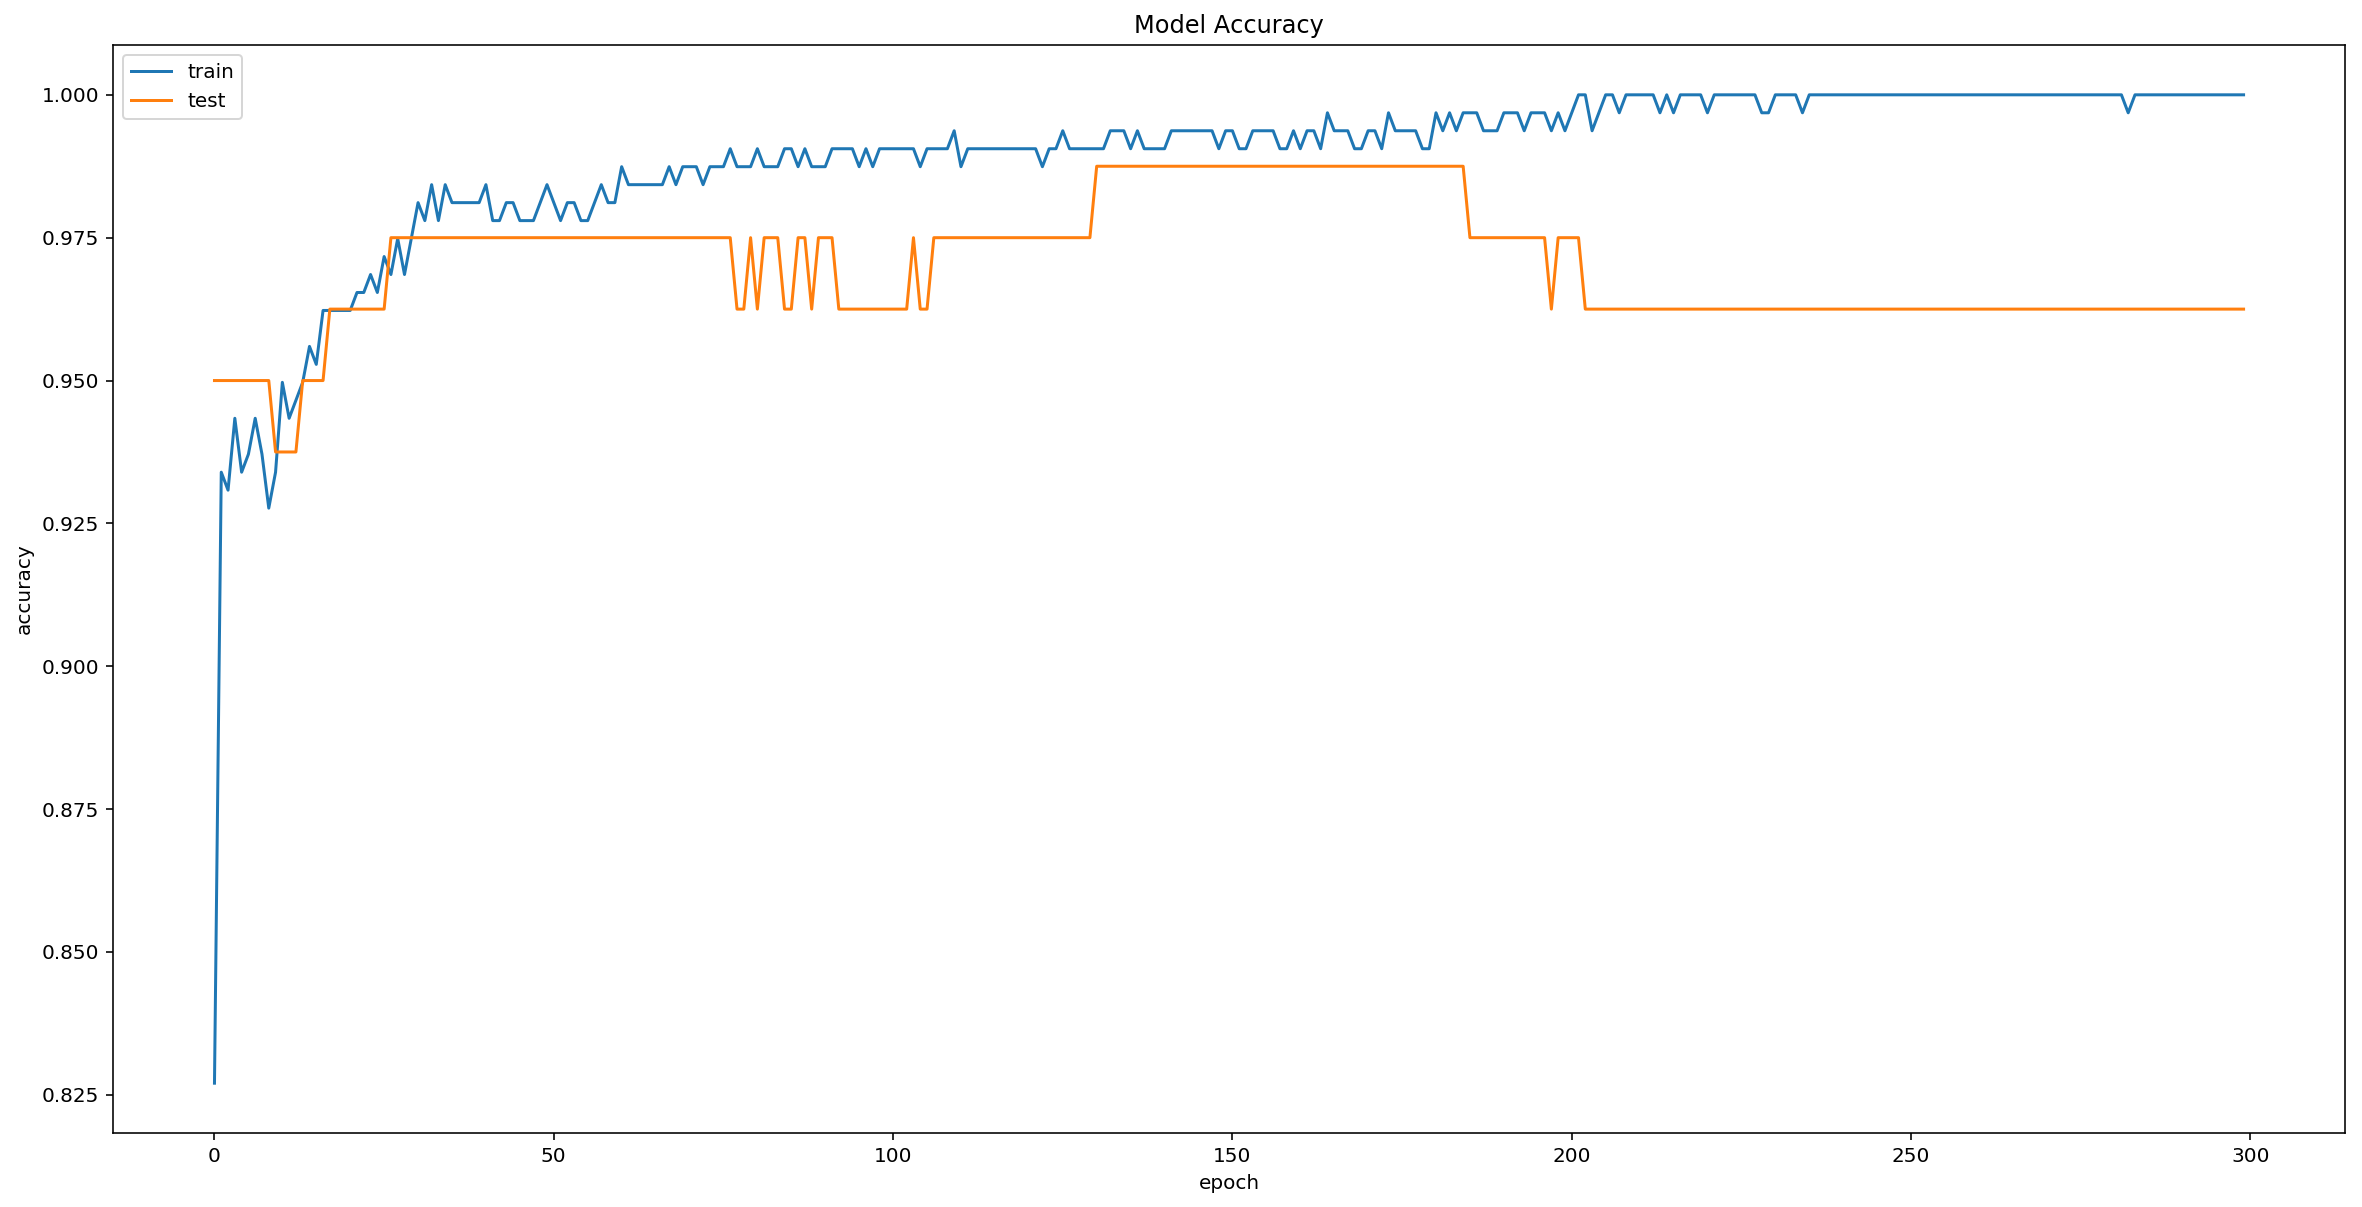

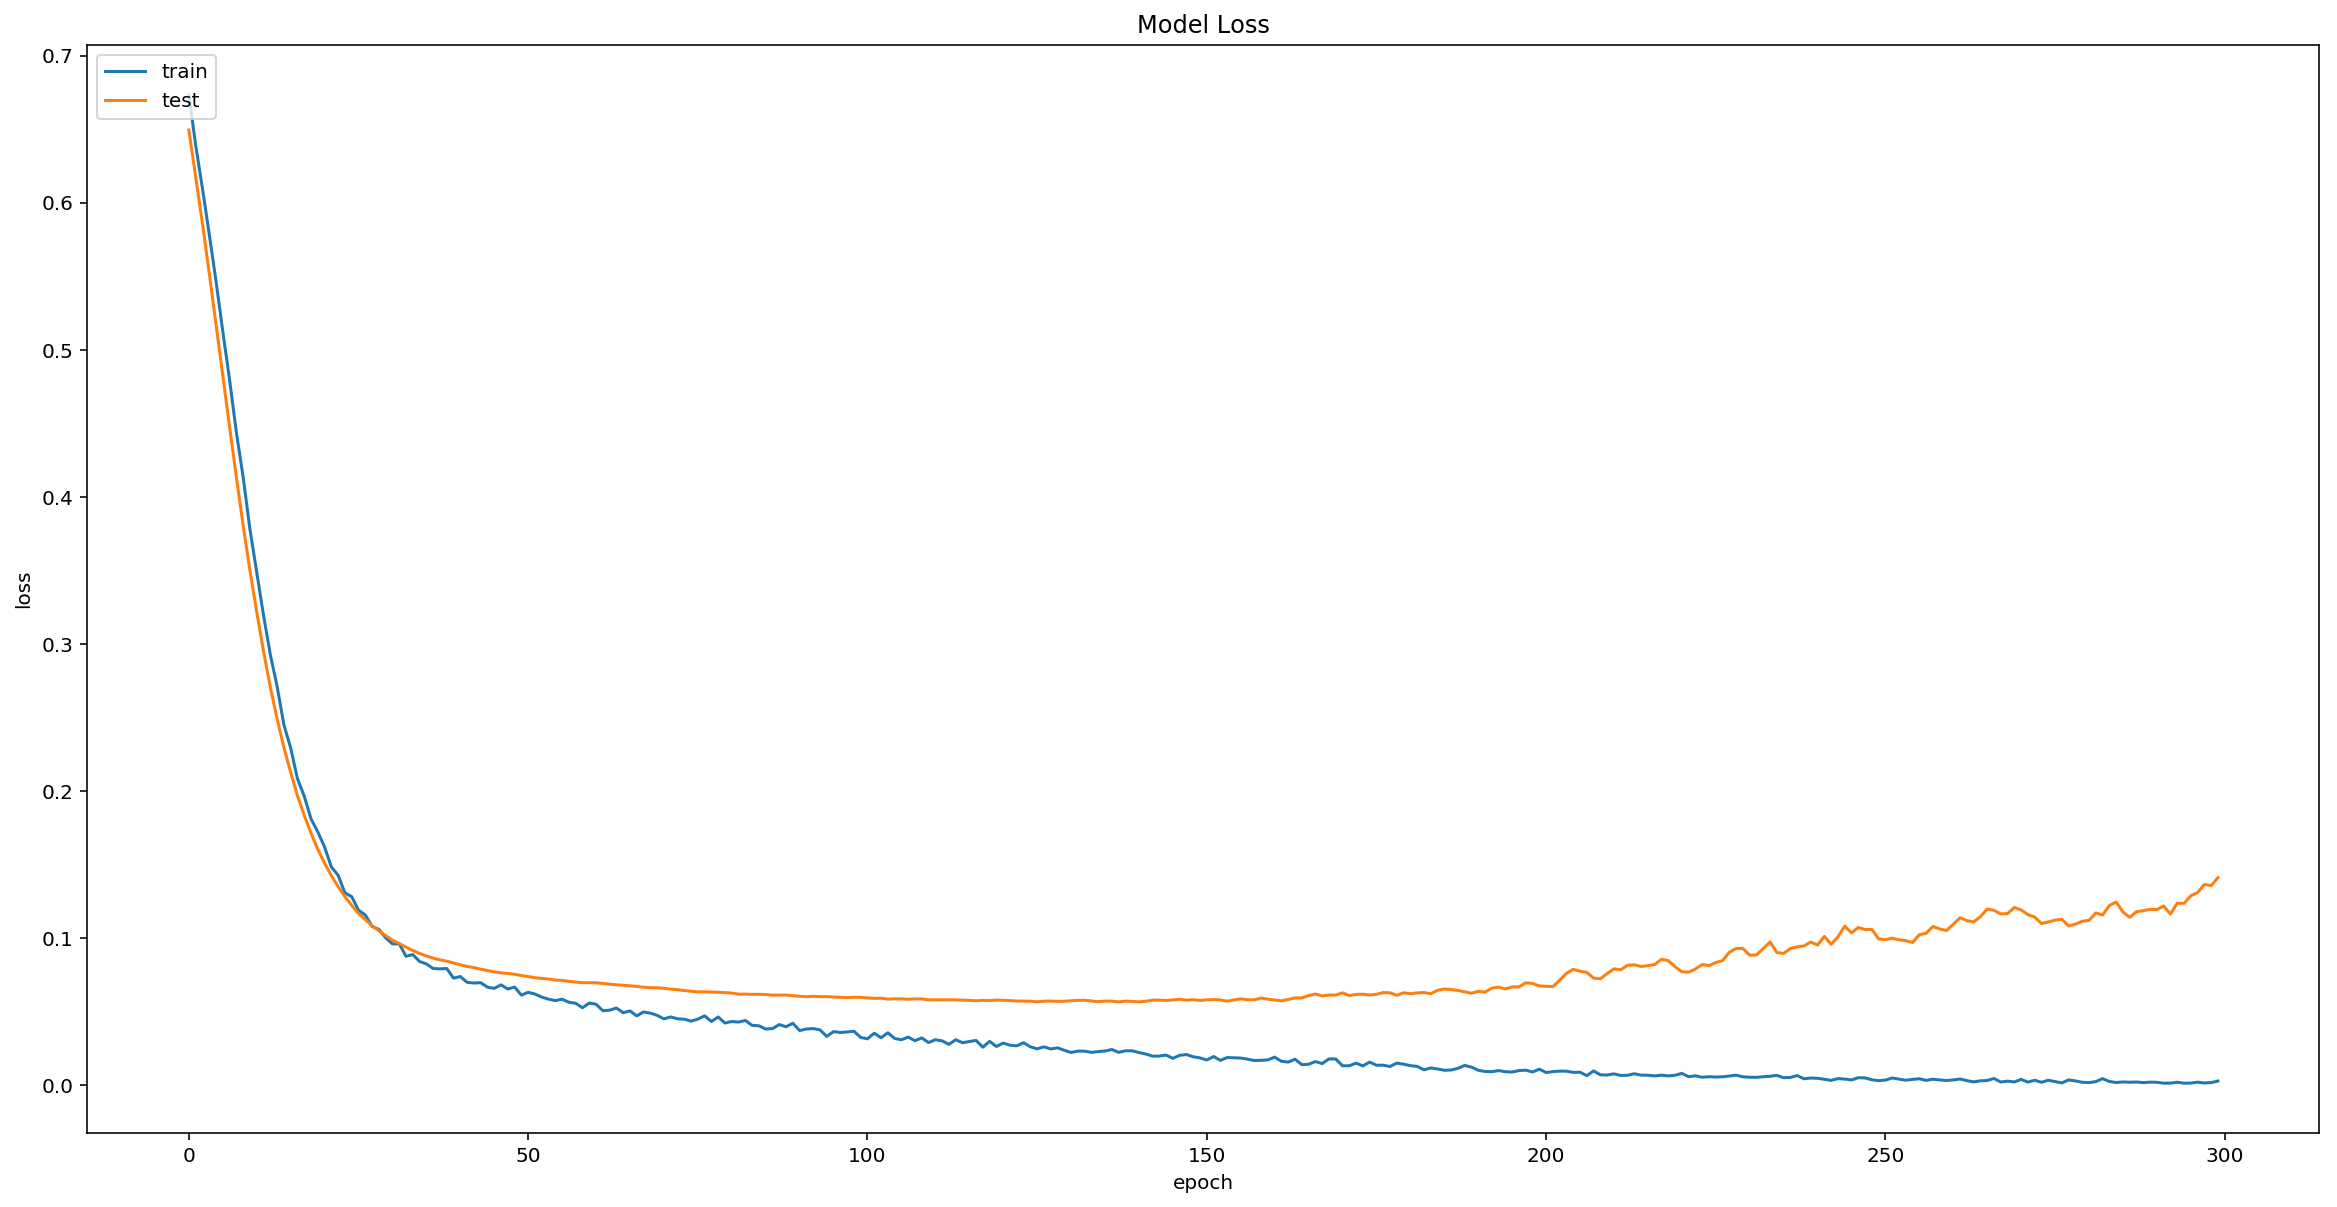

Memory Usage 1.07 MB
Time of Processing 8.92s
Accuracy 99.42%


In [13]:
show_info(model6, X_test_norm, y_test, keras_history6)

In [118]:
y_pred = (model6.predict(X_test) > 0.5).astype(int)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test.values.reshape(-1, 1), y_pred)

array([[  0, 108],
       [  0,  63]])